# Notebook: TCN Model Training and Evaluation

## 1. Importing Libraries and Module

First, we import the required libraries and the module containing our functions.


In [330]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import ta

from keras.src.layers import BatchNormalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models, Input, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Conv1D, BatchNormalization, LSTM
from tcn import TCN
from sklearn.metrics import r2_score, mean_absolute_error

In [331]:
def R2(y_true, y_pred):
    ss_res = tf.reduce_sum(
        tf.square(y_true - y_pred)
    )
    ss_tot = tf.reduce_sum(
        tf.square(y_true - tf.reduce_mean(y_true))
    )

    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())  # sss_tot


def ACCURACY_5(y_true, y_pred):
    # Erreur relative : |y_true - y_pred| / (|y_true| + epsilon) on evite les divisions par 0
    error = tf.abs(
        (y_true - y_pred) / (tf.abs(y_true) + tf.keras.backend.epsilon())
    )
    correct = tf.cast(
        error <= 0.05,
        tf.float32
    )

    return tf.reduce_mean(correct)


def CREATE_SEQUENCES(data, sequence_length, target_column='close'):
    X, y, = [], []
    for i in range(sequence_length, len(data)):
        features = data.iloc[i - sequence_length:i].values
        X.append(features)

        targets = data.iloc[i][target_column]
        y.append(targets)

    return np.array(X), np.array(y)

def NN_MODEL(input_shape, learning_rate=5e-4):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        TCN(
            nb_filters=8,
            kernel_size=6,
            nb_stacks=10,
            dilations=[1, 2, 4, 8],
            padding='causal',
            dropout_rate=0.2,
            return_sequences=True
        ),
        BatchNormalization(),
        
        layers.LSTM(50, return_sequences=True),
        BatchNormalization(),

        layers.LSTM(1, return_sequences=False),
        BatchNormalization(),

        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=[
            'mean_absolute_error',
            R2,
            ACCURACY_5
        ]
    )

    return model

## 2. Data Loading

We load our stock market data from a CSV file and extract the "close" price column.


In [332]:
df = pd.read_csv("/Users/welto/PycharmProjects/company_brandname/technical-and-fundamental-analysis-on-stock-markets/Datasets/NASDAQ_100.csv")
df['sma_20'] = df['close'].rolling(window=20).mean()
df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['bollinger_upper'] = df['sma_20'] + 2 * df['close'].rolling(window=20).std()
df['bollinger_uower'] = df['sma_20'] - 2 * df['close'].rolling(window=20).std()

df.ffill(inplace=True)
df = df.drop(columns=['date'])

## 3. Data Preprocessing

Next, we normalize the close prices using a MinMaxScaler.


In [333]:
scaler_features = MinMaxScaler()
target_scaler = StandardScaler()

target = pd.DataFrame(
    target_scaler.fit_transform(df['close'].values.reshape(-1, 1))
)

df = pd.concat(
    [
        pd.DataFrame(
            scaler_features.fit_transform(
                df.filter(
                    items=[col for col in df.columns if col != 'close']
                )
            ),
            columns=df.filter(
                items=[col for col in df.columns if col != 'close']
            ).columns
        ),
        target,
    ], axis=1
).dropna()
df.rename(
    columns={0: 'close'},
    inplace=True
)

## 4. Creating Sequences


In [334]:
sequence_length = 60 # nombre de features pour l'entrainement (nombre de jours d'entrée)

X, y = CREATE_SEQUENCES(df, sequence_length=sequence_length)
print("X shape :", X.shape, "y shape :", y.shape)

X shape : (9637, 60, 12) y shape : (9637,)


## 5. Splitting the Dataset

We split the data into training (70%), validation (15%), and test (15%) sets.


In [335]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

print("Train shapes :", X_train.shape, y_train.shape)
print("Val shapes  :", X_val.shape, y_val.shape)
print("Test shapes :", X_test.shape, y_test.shape)

Train shapes : (6745, 60, 12) (6745,)
Val shapes  : (1445, 60, 12) (1445,)
Test shapes : (1447, 60, 12) (1447,)


## 6. Building the Model

We build our hybrid TCN+LSTM model using the function from the module.  
Our model takes sequences of shape (sequence_length, nb_features) and predicts a single value (close price).


In [336]:
input_shape = (sequence_length, X.shape[-1])
model = NN_MODEL(input_shape=input_shape)
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_30 (TCN)                    │ (None, 60, 8)          │        31,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 60, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 60, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 1)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 1)              │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,902 (171.49 KB)

 Trainable params: 43,784 (171.03 KB)

 Non-trainable params: 118 (472.00 B)

## 7. Training the Model

We train the model using EarlyStopping and ReduceLROnPlateau to avoid overfitting.


In [337]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
) # on arrete l'entrainement si la loss ne diminue plus sur plusieurs epochs

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1
) # quand la loss ne diminue plus, on baisse le learning rate

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        reduce_lr
    ]
)

Epoch 1/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy_5: 0.0093 - loss: 0.4254 - mean_absolute_error: 0.5055 - r2: -161.5269 - val_accuracy_5: 0.0000e+00 - val_loss: 0.4653 - val_mean_absolute_error: 0.6150 - val_r2: -51780.0938 - learning_rate: 5.0000e-04
Epoch 2/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy_5: 0.0587 - loss: 0.0719 - mean_absolute_error: 0.2229 - r2: -26.6856 - val_accuracy_5: 0.0000e+00 - val_loss: 0.6783 - val_mean_absolute_error: 0.7692 - val_r2: -83356.1875 - learning_rate: 5.0000e-04
Epoch 3/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy_5: 0.0656 - loss: 0.0538 - mean_absolute_error: 0.1891 - r2: -18.3844 - val_accuracy_5: 0.0000e+00 - val_loss: 0.7358 - val_mean_absolute_error: 0.8056 - val_r2: -92062.5312 - learning_rate: 5.0000e-04
Epoch 4/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy_5: 0.0613 - loss: 0.0483 - mean_absolute_error: 0.1823 - r2: -16.5743 - val_accuracy_5: 0.0000e+00 - val_loss: 0.6389 - val_mean_abso

## 8. Plotting the Training Loss

We now plot the training and validation loss curves (MSE) over epochs.


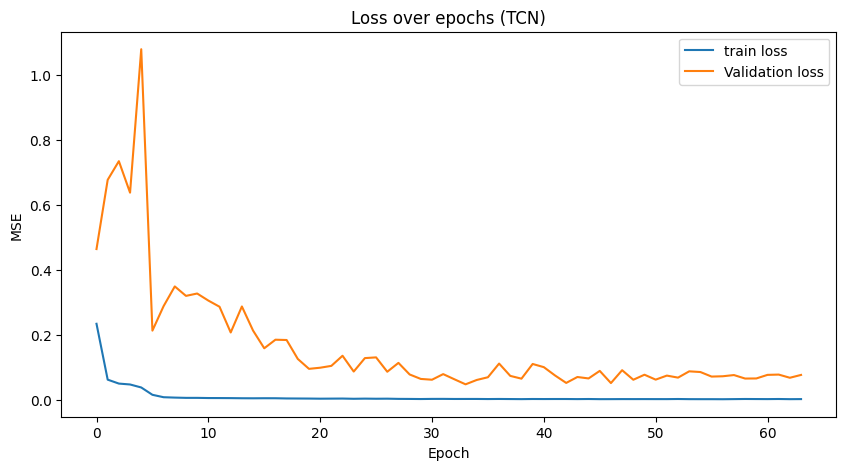

In [338]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.title("Loss over epochs (TCN)")

plt.legend()
plt.show()

## 9. Model Evaluation and Predictions

Next, we evaluate the model on the test set and predict closing prices.


In [339]:
test_loss = model.evaluate(X_test, y_test)
print("Test Loss :", test_loss)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy_5: 0.0000e+00 - loss: 2.7872 - mean_absolute_error: 1.3280 - r2: -20219.4746
Test Loss : [6.160794734954834, 2.1728436946868896, -36210.60546875, 0.0]


## 10. Inverse Scaling and Metrics Calculation

We inverse the scaling to get the original closing price values, then calculate performance metrics (R², MAE, etc.).


In [340]:
# Inverse transform the predictions and true values
y_pred_scaled = model.predict(X_test)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

# Calculate metrics using functions from scikit-learn
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(np.mean((y_test_unscaled - y_pred_unscaled) ** 2))
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mape = mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled) * 100
accuracy = ACCURACY_5(y_test_unscaled, y_pred_unscaled)

print("----- Test Set Performance -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Accuracy (5% tolerance): {accuracy:.2f}%")
print(f"MAPE: {mape:.2f}%")


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
----- Test Set Performance -----
RMSE: 10064.4895
MAE: 8810.5259
R²: -8.4362
Accuracy (5% tolerance): 0.00%
MAPE: 68.48%


## 11. Plotting Predictions vs. Real Values

Finally, we plot the predictions against the real closing prices for the first 100 test samples.


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


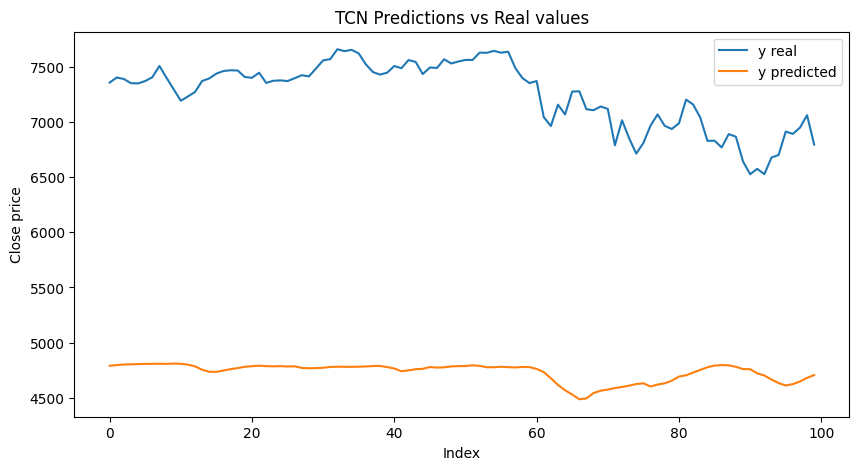

In [341]:
y_pred_scaled = model.predict(X_test)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

n_plot = 100
plt.figure(figsize=(10, 5))
plt.plot(y_test_unscaled[:n_plot], label='y real')
plt.plot(y_pred_unscaled[:n_plot], label='y predicted')
plt.xlabel("Index")
plt.ylabel("Close price")
plt.title("TCN Predictions vs Real values")
plt.legend()
plt.show()